## Feature Engineering


*   The fourth project is the development of a notebook (code + explanation) that successfully engineers 12 unique types of features, **three** for each type of feature engineering: **transforming**, **interacting**, **mapping**, and **extracting**.
* The second part of the assignment is the development of a **deep learning classification** model to predict the direction of the S&P500 for the dates **2018-01-01—2018-07-12** (test set).
* The feature engineering section is unrelated to the model section, you can develop any features, not just features that would work for deep learning models (later on you can decide which features to use in your model).
*  You also have to uncomment all the example features and make them run successfully  → **every** feature example has some error/s that you have to fix. Please also describe the error you fixed!
*   Note that we *won't* be attempting to measure the quality of every feature (i.e., how much it improves the model), that is slightly too advanced for this course.


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [68]:
# preparing our data
raw_prices = pd.read_csv("https://open-data.s3.filebase.com/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67,0
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03,1
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63,0
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69,1
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21,0


### Train Test Split

In [69]:
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train = X[X.index.astype(str)<'2018-01-01'].copy()
y_train = y[X_train.index].copy()
X_test = X[~X.index.isin(X_train.index)].copy()
y_test = y[X_test.index].copy()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### EDA

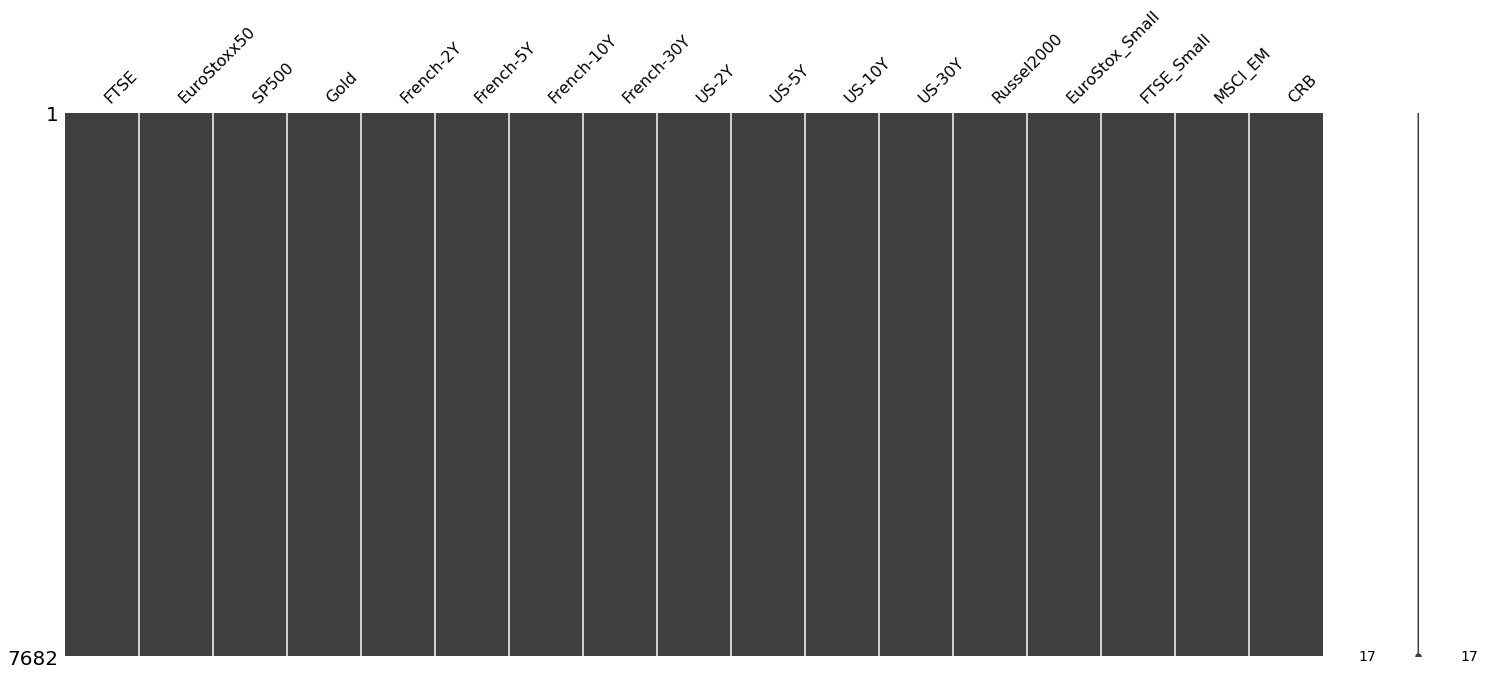

In [70]:
# no missing value
import missingno as ms
ms.matrix(df)

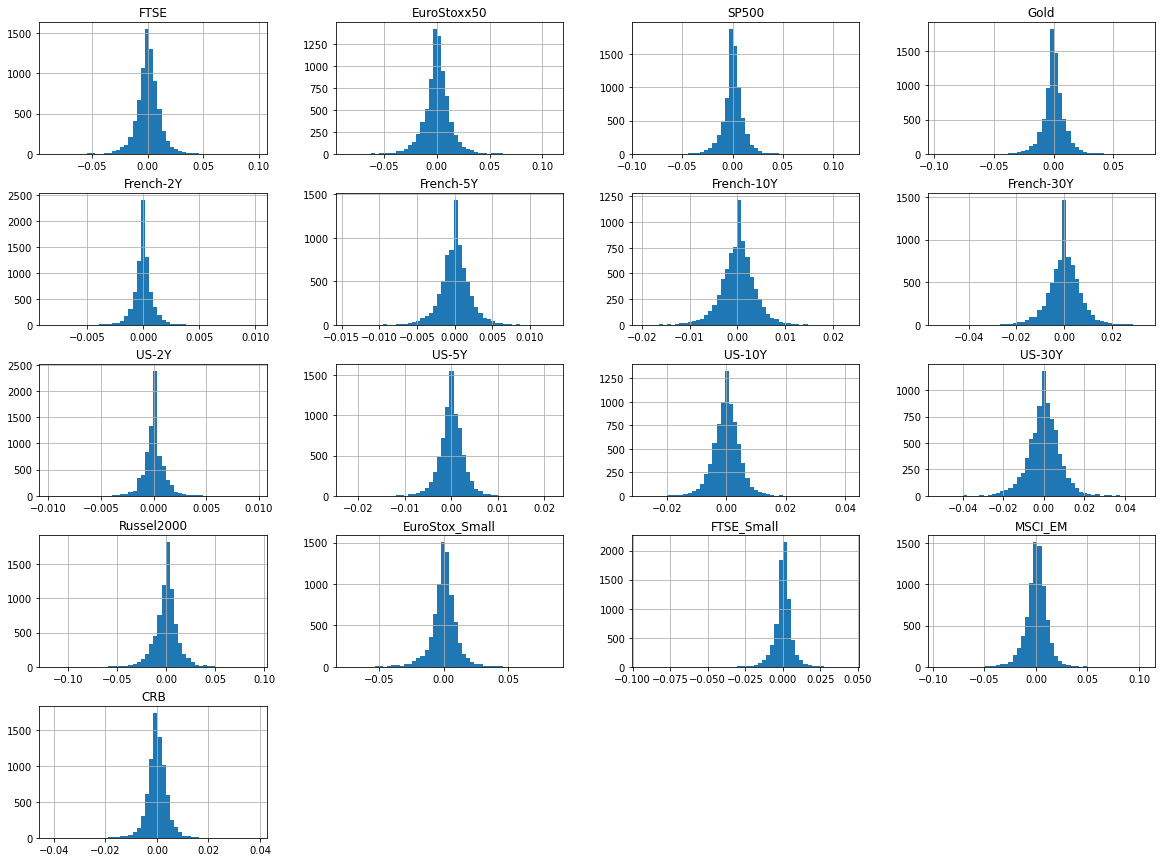

In [71]:
# the return distributions seem to have high kurtosis
df_return = df.pct_change().iloc[1:, :]
df_return.hist(bins=50, figsize=(20,15))
plt.show()

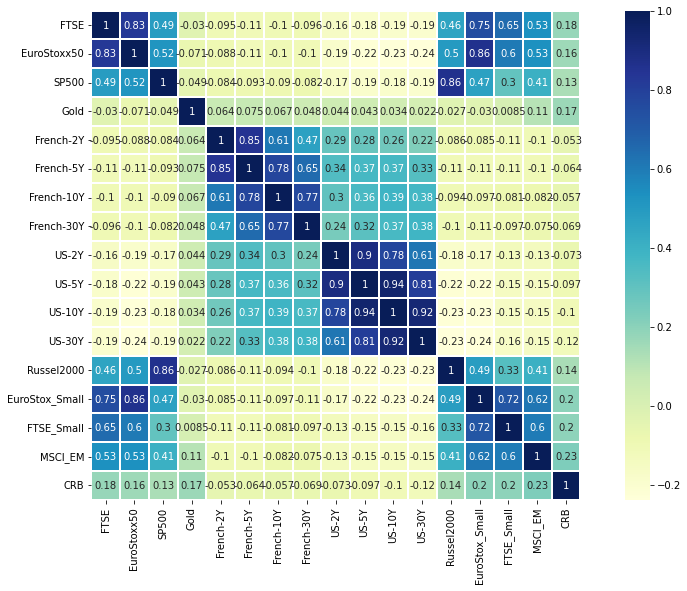

In [72]:
# The 4 French (US) treasuries return seem to have high positive correlations, we might need apply some dimension reduction techniques.
plt.figure(figsize=(16,9))
sns.heatmap(df_return.corr(), cmap="YlGnBu",annot=True, fmt=".2g", linewidths = 1, square= True)

### Transforming

1. Refresh your mind on tranformation methods by going back to the material. I am simply providing 1 example here. 
1. Don't repeat my logarithmic return calculation, develop your own transformation (there are 1000s of types of transformations).
1. In the example I provide, there is also an error that you have to fix. For example, one of the errors below is that you should actually use `np.log1p()`, but there is another one, so watch out! 

In [24]:
# Example Transforming (has errors) 

# Name: Logarithmic return of FTSE 
# Description: Developing the logarithmic return feature for use within linear models that make normality assumptions. 

'''
Here we need to change np.log to np.log1p because sometimes the percentage change of FTSE price is very close to 0, leading to the logged value very close to negative infinity. Therefore, we need to apply log(1+x)
to make sure the logged value is not extremely big.
''' 
df["FTSE_log"] = np.log1p(df["FTSE"].pct_change()) 

'''
Also, since pct_change() will make the value in the first row NaN, we need to delete the first row or replace it by a default value. Here I just choose 0 as the default logged value.
'''
df["FTSE_log"][0] = 0.0

In [ ]:
## Transforming 1 (Add code below)
'''
Name: Discretized return of FTSE

Description: Daily return of FTSE is discretized into 3 classes: 1 (returns above 1%), -1 (returns below -1%) and 0 (returns between -1% and 1%). 
                    This feature distinguishes large returns from small returns and treat equally to all returns in the same group. 
'''

def discretize(r):
    if r > 0.01: return 1;
    elif r < -0.01: return -1;
    else: return 0;

df["FTSE_r_dis"] = df["FTSE"].pct_change()
df = df.drop(df.index[0])  # delete the first row with NaN
df["FTSE_r_dis"] = df["FTSE_r_dis"].map(discretize)



In [ ]:
## Transforming 2 (Add code below)

'''
Name: Scaled return of FTSE

Description: Daily return of FTSE is scaled by robust scaler: r_scaled = (r – Q2)/(Q3 – Q1) to deal with potential outliers.
'''

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# we need to do the scaling to training set and test set seperately in order to avoid data leakage
X_train.loc[:,("FTSE_r_scaled")] = X_train["FTSE"].copy().pct_change()
X_train = X_train.drop(X_train.index[0])  # delete the first row with NaN
y_train = y_train.drop(y_train.index[0]) # the size of y need to be aligned to x
X_train["FTSE_r_scaled"] = scaler.fit_transform(X_train[["FTSE_r_scaled"]].copy())

X_test["FTSE_r_scaled"] = X_test["FTSE"].copy().pct_change()
X_test = X_test.drop(X_test.index[0])  # delete the first row with NaN
y_test = y_test.drop(y_test.index[0]) # the size of y need to be aligned to x
X_test["FTSE_r_scaled"] = scaler.transform(X_test[["FTSE_r_scaled"]].copy()) 


In [ ]:
## Transforming 3 (Add code below)
'''
Name: Gaussian-like return of FTSE

Description: Daily returns of FTSE is power transformed by yeo-johnson method for use within linear models that make normality assumptions. 
'''


from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method="yeo-johnson")

# we need to do the yeo-johnson transformation to training set and test set seperately in order to avoid data leakage
X_train["FTSE_r_gauss"] = X_train["FTSE"].copy().pct_change()
X_train = X_train.drop(X_train.index[0])  # delete the first row with NaN
y_train = y_train.drop(y_train.index[0]) # the size of y need to be aligned to x
X_train["FTSE_r_gauss"] = pt.fit_transform(X_train[["FTSE_r_gauss"]].copy())

X_test["FTSE_r_gauss"] = X_test["FTSE"].copy().pct_change()
X_test = X_test.drop(X_test.index[0])  # delete the first row with NaN
y_test = y_test.drop(y_test.index[0]) # the size of y need to be aligned to x
X_test["FTSE_r_gauss"] = pt.transform(X_test[["FTSE_r_gauss"]].copy())



### Interacting

There are millions of possible interaction methods, be creative and come up with your own. For this assignment there is no 'right' feature engineering method, you simply develop one, and give it a name and a discreption.

In [25]:
# Example Interacting (has errors) 

# Name: Ratio of Gold return to 10Y treasury
# Desciption: Both gold and treasuries are safe-haven assets and descrepency in their ratio could be a sign of some marco-economic event.

'''
There should be a pct_change() function after df["Gold"] because it makes no sense to divide gold price by 10y treasury return. 
'''
def gold_to_yield(df):
    teny_returns = df["US-10Y"].copy().pct_change()
    gold_returns = df["Gold"].copy().pct_change()
    # df = df.drop(df.index[0])
    df["gold_r__div__teny_r"] = gold_returns/teny_returns
    return df

X_train = gold_to_yield(X_train); X_test = gold_to_yield(X_test)

'''
Sometimes the teny_returns is very close to 0 so the ratio becomes NaN. We need to delete the rows with NaN values.
'''
X_train = X_train.dropna(axis=0,how='any'); X_test = X_test.dropna(axis=0,how='any')



In [ ]:
## Interacting 1 (Add code below)

'''
Name: Pair Trading Indicator

Description: Absolute value of the difference of (FTSE price / SP500 price) can be regarded as a pair trading indicator. If the indicator is larger than some threshold (e.g. k*sigma), we short the pair;
                    otherwise we long the pair.
'''

df["FTSE/SP500_diff_abs"] = (df["FTSE"]/df["SP500"]).diff().abs()
df = df.drop(df.index[0])  # delete the first row with NaN

In [ ]:
## Interacting 2 (Add code below)
'''
Name: Size premium return of FTSE (small minus big)

Description: FTSE_small daily return minus FTSE return shows how small companies outperform the big ones. This indicator is useful in some linear regression models like Fama-French 3 Factor Model.

'''

df["FTSE_smb_r"] = df["FTSE_Small"].pct_change()-df["FTSE"].pct_change()
df = df.drop(df.index[0])  # delete the first row with NaN

In [ ]:
## Interacting 3 (Add code below)

'''
Name: Europe and America benchmark return

Description: This is a capitalisation-weighted average return of the 3 famous indices for companies listed on different exchanges in United States and Europe. This indicator can to some extent capture
                    the global financial situation.

'''
#  calculate the capitalisation-weight for each index
FTSE_w = 2.213/(2.213+36.7+3.846)
SP500_w = 36.7/(2.213+36.7+3.846)
EuroStoxx50_w = 3.846/(2.213+36.7+3.846)

df["E&A_r"] = FTSE_w * df["FTSE"].pct_change() + SP500_w * df["SP500"].pct_change() + EuroStoxx50_w * df["EuroStoxx50"].pct_change()
df = df.drop(df.index[0])  # delete the first row with NaN


### Mapping

This one is slightly harder, you have to identify other  dimensionality reduction methods, there are many more than just PCA. Maybe you can also look at performing the decompositions just on a single asset classes, e.g., US-2Y, US-5Y, US-10Y, US-30Y is a fixed income asset class, but there are a few others in the dataset.

In [29]:
# Example Mapping (has errors) 

# Name: First prinicipal component of all of the assets returns
# Description:For stocks the first component resmbles the return of the market, for multiple asset classes it could resemble a 'universal' asset class


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_first(X_train, X_test):
    sc = StandardScaler()
    # The PCA component is calculated based on assets returns so actually we should standardize the daily returns.
    X_train_s = sc.fit_transform(X_train.pct_change().fillna(0))
    X_test_s = sc.transform(X_test.pct_change().fillna(0))

    # X_train_s and X_test_s are numpy.ndarray objects which does not have attribute 'fillna'. So we should replace the NaN value in this way.
    X_train_s[np.isnan(X_train_s)] = 0
    X_test_s[np.isnan(X_test_s)] = 0

    pca = PCA(1)
    X_train["first_prinicipal"] = pca.fit_transform(X_train_s)
    X_test["first_prinicipal"] = pca.transform(X_test_s)
    return X_train, X_test

X_train, X_test = pca_first(X_train, X_test)

# ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
## Mapping 1 (Add code below)
'''
Name: LDA component of all of the assets returns

Description: The LDA component of assets return differentiates the two directions of S&P500 in the targets. It can be a useful indicator for predicting the target value.

'''

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda(X_train, y_train, X_test):
    clf = LinearDiscriminantAnalysis(n_components = 1)
    X_train["lda_component"] = clf.fit_transform(X_train.pct_change().fillna(0), y_train)
    X_test["lda_component"] = clf.transform(X_test.pct_change().fillna(0))
    return X_train, X_test

X_train, X_test = lda(X_train, y_train, X_test)


In [5]:
## Mapping 2 (Add code below)
'''
Name: 3-means clustering distances of all the assets returns

Description: Distances to three different cluster centers implicitly classifies the all assets returns, useful for predicting price direction.
'''

from sklearn.cluster import KMeans

def K_means(X_train, X_test):
    kmeans = KMeans(n_clusters=3, random_state=0)
    X_train[["kmeans_distance1", "kmeans_distance2", "kmeans_distance3"]] = kmeans.fit_transform(X_train.pct_change().fillna(0))
    X_test[["kmeans_distance1", "kmeans_distance2", "kmeans_distance3"]] = kmeans.transform(X_test.pct_change().fillna(0))
    return X_train, X_test

X_train, X_test = K_means(X_train, X_test)

In [22]:
## Mapping 3 (Add code below)
'''
Name: NMF component of US Treasury prices

Description: For US Treasury classes the NMF component represents an overall US fixed income assets price indicator.
'''

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

def nmf(X_train, X_test):
    sc = MinMaxScaler(clip = True)
    X_train_s = sc.fit_transform(X_train[["US-2Y", "US-5Y", "US-10Y", "US-30Y"]])
    X_test_s = sc.transform(X_test[["US-2Y", "US-5Y", "US-10Y", "US-30Y"]])

    model = NMF(n_components=1, random_state=0)
    X_train["UStreasury_NMF"] = model.fit_transform(X_train_s)
    X_test["UStreasury_NMF"] = model.transform(X_test_s)
    return X_train, X_test

X_train, X_test = nmf(X_train, X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Extracting

In [33]:
# Example Extracting (has errors) 
# Name: Annualized volatility in returns
# Description: We are developing an annualized volatility measure for all asset returns, which is a good measure of market turbulence

def vola(df):
    volatility = df.pct_change().rolling(window=365).std()*(365**0.5) #this line is correct
    new_names = [(i,i+'_vol') for i in df.columns.values]
    volatility.rename(columns = dict(new_names), inplace=True)
    df = pd.concat((df, volatility), axis=1)
    return df

X_train = vola(X_train); X_test = vola(X_test)

'''
We need to delete the first 365 rows of training data and test data which has NaN values.
'''

X_train = X_train.dropna(axis=0,how='any'); X_test = X_test.dropna(axis=0,how='any')

'''
Note that the test dataset has fewer than 365 rows so if we delete the rows containing NaN, no data is left in the testset!
In this case, maybe we need to resplit the train and test data and make sure the size of test data is at least larger than 365.

By the way, I think it makes more sense that we use the number of trading days (252) instead of calender days (365) when calculating the annualized volatility.
'''

'\nNote that the test dataset has fewer than 365 rows so if we delete the rows containing NaN, no data is left in the testset!\nIn this case, maybe we need to resplit the train and test data and make sure the size of test data is at least larger than 365.\n\nBy the way, I think it makes more sense that we use the number of trading days (252) instead of calender days (365) when calculating the annualized volatility.\n'

In [ ]:
## Extracting 1 (Add code below)
'''
Name: 5-lagged simple moving average price of FTSE

Description: Simple moving average price is a widely-used technical indicator showing the short term and long term trends.
'''
X_train["FTSE_sma_lag5"] = X_train["FTSE"].rolling(window=5).mean()
X_train = X_train.drop(X_train.index[:4])  # delete the first 4 rows with NaN
y_train = y_train.drop(y_train.index[:4]) # the size of y need to be aligned to x

X_test["FTSE_sma_lag5"] = X_test["FTSE"].rolling(window=5).mean()
X_test = X_test.drop(X_test.index[:4])  # delete the first 4 rows with NaN
y_test = y_test.drop(y_test.index[:4]) # the size of y need to be aligned to x


In [ ]:
## Extracting 2 (Add code below)
'''
Name: Annualized Sharpe Ratio (assume risk-free rate r = 0)

Description: Sharpe ratio is a risk-adjusted measure of an investment. It helps us understand the return of an investment compared to its risk. Note here we assume r = 0.

'''

def sharpe(df):
    volatility = df.pct_change().rolling(window=252).std()*(252**0.5) 
    risk_premium = df.pct_change().rolling(window=252).sum()
    sharpe_ratio = risk_premium/volatility
    new_names = [(i,i+'_asr') for i in df.columns.values]
    sharpe_ratio.rename(columns = dict(new_names), inplace=True)
    df = pd.concat((df, sharpe_ratio), axis=1)
    return df

X_train = sharpe(X_train); X_test = sharpe(X_test)
X_train = X_train.drop(X_train.index[:252]); X_test = X_test.drop(X_test.index[:252]) # delete the first 252 rows with NaN
y_train = y_train.drop(y_train.index[:252]); y_test = y_test.drop(y_test.index[:252]) # the size of y need to be aligned to x





In [ ]:
## Extracting 3 (Add code below)

'''
Name: 20-day ratio of upward move to downward move

Description: This indicator is calculated by dividing the no. of days with price rise by no. of days with price fall during the previous 20 days. It is another way to reveal the short term trend and oscillation.

'''
def up_to_down_ratio(df):
    up = df.diff().rolling(window=20).apply(lambda s: sum(s > 0))
    down = 20 - up
    ratio = up / down
    new_names = [(i,i+'_UDratio') for i in df.columns.values]
    ratio.rename(columns = dict(new_names), inplace=True)
    df = pd.concat((df, ratio), axis=1)
    return df

X_train = up_to_down_ratio(X_train); X_test = up_to_down_ratio(X_test)
X_train = X_train.drop(X_train.index[:20]); X_test = X_test.drop(X_test.index[:20]) # delete the first 20 rows with NaN
y_train = y_train.drop(y_train.index[:20]); y_test = y_test.drop(y_test.index[:20]) # the size of y need to be aligned to x




## Deep Learning Binary Classification

* For the deep learning model you can perform new data preprocessing methods and new feature engineering that are better suited to neural networks. You can also use all or some of the features you developed above (most features work in deep learning models as long as they are normalized).
* It is very hard to predict the stock price, so in my grading I will look more at the quality of the model you process (e.g., that there is no data leakage, that you performed some hyperparameter tuning).
* Make sure that you switch your GPU on, you have access to it on Colab. The training stage also takes long, you might want to use a smaller amount of data, or fewer epochs at first to speed up your development process.
* After your training is done, you don't have to save your model, but you do have to print the performance of your model. You can report two metrics the ROC(AUC) and the Accuracy against the test set. 
* Also remember to set the random seed (random state) so that when I run your software, I get similar results (the results doesn't have to be exactely the same). 
* You can choose any type of deep learning archetecture, e.g., LSTM, GRU, CNN, it is up to you.
* Remember that this section is less that 25% of the grade, so don't waste your time here. 
* And lastly, remember this is the stock market, so it is **difficult** to have an accuracy above 50%, good luck!

In [105]:
## Implement Here
# preparing our data
raw_prices = pd.read_csv("https://open-data.s3.filebase.com/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df = df.pct_change().iloc[1:, :]  # we convert the price data into return data first!!!
df["target"] = df["SP500"].shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-02,0.001814,0.002981,-0.000841,-0.001274,-0.001847,0.000788,-0.002953,-0.003080,-0.000310,-0.000309,-0.000623,-0.000304,0.003627,0.001617,0.003892,0.010989,0.001256,1
1989-02-03,0.012969,0.006844,0.000438,-0.008291,0.000091,-0.001160,-0.001340,-0.005156,-0.001880,-0.002512,-0.000950,-0.001835,0.004841,0.007902,0.009842,0.015416,-0.004878,0
1989-02-06,-0.012368,0.001584,-0.003132,-0.001929,-0.004277,-0.005050,-0.006405,-0.014509,0.000000,0.000000,-0.001258,-0.002458,-0.000707,0.002276,-0.001356,-0.000707,-0.003291,1
1989-02-07,0.013941,-0.001886,0.012127,0.012242,-0.000467,-0.001929,-0.002213,-0.000522,0.000942,0.001889,0.003472,0.006150,0.008099,-0.005131,0.003561,-0.000898,-0.001686,0
1989-02-08,0.011289,0.009040,-0.003271,-0.005729,0.001219,0.003519,0.004721,0.002099,-0.000941,-0.000948,-0.001266,-0.004280,0.001020,0.003805,0.011481,0.000825,0.000598,0


In [106]:
# train, validation, test split
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train = X[X.index.astype(str)<'2015-01-01'].copy()
y_train = y[X_train.index].copy()
X_validation = X[(X.index.astype(str) >='2015-01-01') & (X.index.astype(str) <'2018-01-01')].copy() # I split a validation dataset here to do the hyperparameter selecting
y_validation = y[X_validation.index].copy()
X_test = X[X.index.astype(str)>='2018-01-01'].copy()
y_test = y[X_test.index].copy()

In [107]:
# normalization
from sklearn.preprocessing import StandardScaler

def standardize(X_train, X_valid, X_test):
    sc = StandardScaler()

    X_train_s = sc.fit_transform(X_train)
    X_valid_s = sc.transform(X_valid)
    X_test_s = sc.transform(X_test)

    return X_train, X_valid, X_test

X_train, X_validation, X_test = standardize(X_train, X_validation, X_test)

## Deep Q-network model

I applied the Deep Q-network (DQN) model that I introduced in my blog post: https://medium.com/@murrawang/deep-q-network-and-its-application-in-algorithmic-trading-16440a112e04.
DQN model can used to predict the price direction because actions (short or long) the agent chooses give indications about if next day's return is positive or negative, so we can regard the actions chosed by the agent as our predictions.

Here I made some modifications on the original model in the post. I reduced the action space from 3 (short, neutral, long) to 2 (short, long) for direction prediction. I also changed the state space from 1 time sries returns to multiple time series returns (17 in total). Therefore, the state space is actually a 2D matrix (k_value * num_of_assets). I flattened the matrix to 1D before feeding it into the MLP network.

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np


class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # input layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # hidden layer
        self.fc3 = nn.Linear(hidden_dim, action_dim)  # output layer

    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity  # capacity of buffer
        self.buffer = []  # replay buffer
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        ''' replay buffer is a queue (LIFO)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


class DQN:
    def __init__(self, state_dim, action_dim, cfg):

        self.action_dim = action_dim
        self.device = cfg.device  # cpu or gpu
        self.gamma = cfg.gamma  # discount factor
        self.frame_idx = 0  # attenuation
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
                                         (cfg.epsilon_start - cfg.epsilon_end) * \
                                         math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),
                                       self.policy_net.parameters()):  # copy parameters to target net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # optimizer
        self.memory = ReplayBuffer(cfg.memory_capacity)  # experience replay

    def get_policy_net(self):
        return self.policy_net
    
    def set_policy_net(self, net):
        self.policy_net = net

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()  # choose the action with maximum q-value
        else:
            action = random.randrange(self.action_dim)
        return action

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # transfer to tensor
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        # calculate the expected q-value, for final state, done_batch[0]=1 and the corresponding
        # expected_q_value equals to reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        # update the network
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():  # avoid gradient explosion by using clip
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

## Trading Environment

In [109]:
import random

class TradingSystem_v0:
    def __init__(self, returns_data, k_value):
        self.data = returns_data.copy()
        self.k = k_value
        self.r_ts = returns_data["SP500"].copy().to_numpy()
        self.total_steps = returns_data.shape[0] - self.k
        self.current_step = 0
        self.initial_state = returns_data.iloc[:self.k, :].copy().to_numpy().flatten()  # we need to flatten the dataframe here as input of the MLP
        self.state = np.copy(self.initial_state)
        self.reward = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True
        if action == 0:
            self.reward = -self.r_ts[self.current_step + self.k - 1]
        else:
            self.reward = self.r_ts[self.current_step + self.k - 1]
        self.state = self.data.iloc[self.current_step:(self.k + self.current_step), :].copy().to_numpy().flatten()
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.total_steps = self.data.shape[0] - self.k
        self.current_step = 0
        self.initial_state = self.data.iloc[:self.k, :].copy().to_numpy().flatten()
        self.state = np.copy(self.initial_state)
        self.reward = 0.0
        self.is_terminal = False
        return self.state

## Configs, Training and Testing functions

In [110]:
import gym
import torch
import numpy as np
import random
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix


class Config:
    '''
    hyperparameters
    '''

    def __init__(self, k_value, feature_num, hidden_dim):
        ################################## env hyperparameters ###################################
        self.algo_name = 'DQN' # algorithmic name
        self.env_name = 'TradingSystem_v0' # environment name
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # examine GPU
        self.seed = 11 # random seed
        self.train_eps = 1 # training episodes
        self.k = k_value #  (K-value)
        self.features = feature_num # number of features (Here is the number of columns in the dataset)
        self.state_space_dim = self.k*self.features # state space size
        self.action_space_dim = 2 # action space size (short: 0, long: 1)
        ################################################################################

        ################################## algo hyperparameters ###################################
        self.gamma = 0.95  # discount factor
        self.epsilon_start = 0.90  # start epsilon of e-greedy policy
        self.epsilon_end = 0.01  # end epsilon of e-greedy policy
        self.epsilon_decay = 500  # attenuation rate of epsilon in e-greedy policy
        self.lr = 0.0001  # learning rate
        self.memory_capacity = 1000  # capacity of experience replay
        self.batch_size = 64  # size of mini-batch SGD
        self.target_update = 100  # update frequency of target network
        self.hidden_dim = hidden_dim  # dimension of hidden layer
        ################################################################################


def train_and_validate(train_data, valid_data, valid_label, cfg):
    print('Start Training!')
    print(f'Environment：{cfg.env_name}, Algorithm：{cfg.algo_name}, Device：{cfg.device}')
    env = TradingSystem_v0(train_data, cfg.k)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    count = 0
    for i_ep in range(cfg.train_eps):
        print(f'Episode：{str(i_ep+1)}')
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)  # save transition
            state = next_state
            agent.update()
            count += 1
            if count % cfg.target_update == 0:  # update target network
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
            if done:
                break
    print('Finish Training!')

    mlp = agent.get_policy_net()
    # Test does not use e-greedy policy, so we set epsilon to 0
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0

    print('Start Validating!')
    print(f'Environment：{cfg.env_name}, Algorithm：{cfg.algo_name}, Device：{cfg.device}')
    env = TradingSystem_v0(valid_data, cfg.k)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    agent.set_policy_net(mlp) # load the trained net
    actions = [] # record actions with max Q-value (can also be regarded as price direction !!!!!)
    state = env.reset()
    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        state = next_state
        actions.append(action)
        if done:
            break
    print('Finish Validating!')
    accuracy = accuracy_score(valid_label[(cfg.k-1):(len(valid_label)-1)].to_numpy(), actions)
    return mlp, accuracy

def test(test_data, test_label, cfg, policy_net):
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    print('Start Testing!')
    print(f'Environment：{cfg.env_name}, Algorithm：{cfg.algo_name}, Device：{cfg.device}')
    env = TradingSystem_v0(test_data, cfg.k)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    agent.set_policy_net(policy_net) # load the trained net
    actions = [] # record actions with max Q-value (can also be regarded as price direction !!!!!)
    state = env.reset()
    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        state = next_state
        actions.append(action)
        if done:
            break
    print('Finish Testing!')
    accuracy = accuracy_score(test_label[(cfg.k-1):(len(test_label)-1)].to_numpy(), actions)
    confusion = confusion_matrix(test_label[(cfg.k-1):(len(test_label)-1)].to_numpy(), actions)
    return accuracy, confusion

## Hyperparameter Tuning

In [111]:
# hyperparameter grids
features_list = df.columns.to_list()
hidden_dim_list = [32,64,128,256,512,1024]
k_list = [5, 10, 20, 50, 100]

# metric list
accuracy_list = []

# first determine the best number of hidden nodes 
for hidden_dim in hidden_dim_list:
    cfg = Config(k_value = 50, feature_num=len(features_list), hidden_dim=hidden_dim)
    # set random seeds
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    _, accuracy = train_and_validate(X_train[features_list], X_validation[features_list], y_validation, cfg)
    accuracy_list.append(accuracy)

Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：Tr

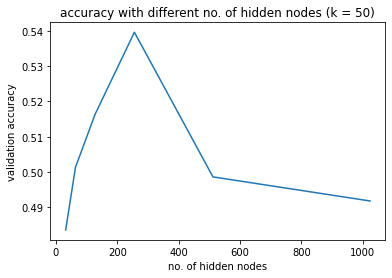

In [112]:
# we should set hidden_dim = 256
plt.plot(hidden_dim_list, accuracy_list)
plt.title("accuracy with different no. of hidden nodes (k = 50)")
plt.xlabel("no. of hidden nodes")
plt.ylabel("validation accuracy")
plt.show()

In [113]:
# metric list
accuracy_list = []

# next choose the best k value
for k_value in k_list:
    cfg = Config(k_value = k_value, feature_num=len(features_list), hidden_dim=256) # Here we fix hidden_dim = 256
    # set random seeds
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    _, accuracy = train_and_validate(X_train[features_list], X_validation[features_list], y_validation, cfg)
    accuracy_list.append(accuracy)

Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!


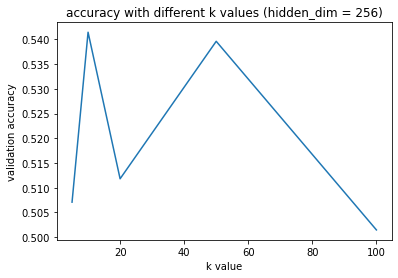

In [114]:
# we should set k_value = 10
plt.plot(k_list, accuracy_list)
plt.title("accuracy with different k values (hidden_dim = 256)")
plt.xlabel("k value")
plt.ylabel("validation accuracy")
plt.show()

## Result on Test Set

In [115]:
cfg = Config(k_value = 10, feature_num=len(features_list), hidden_dim=256)
# set random seeds
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)
model, val_accuracy = train_and_validate(X_train[features_list], X_validation[features_list], y_validation, cfg)

test_accuracy, confusion = test(X_test[features_list], y_test, cfg, model)

Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Episode：1
Finish Training!
Start Validating!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Validating!
Start Testing!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda
Finish Testing!


In [116]:
val_accuracy

0.5414507772020726

In [117]:
# The model can correctly predict about 56% of S&P500 daily price directions.
test_accuracy 

0.5581395348837209

In [118]:
# We got a relatively high false positive rate, meaning for many days we predict the price will go up while it actually goes down.
confusion

array([[24, 36],
       [21, 48]])

For DQN model we cannot plot the ROC(AUC) plot because output of the network here are estimated Q-values for each action instead of the probability of each direction. Therefore, setting thresholds does not make sense in DQN model.